#### First issue: in the ideal scenario, WLS does not recover your desired coefficients if $X$ is not fixed

Below is a simulation where we have 
$$\mu_y(e) = \alpha \mu_x(e)$$
where $e$ stands for different experiments. Let's pretend we only have 1 measurement per experiment but we know that the measurements are Gaussian:
$$\binom{x_i(e)}{y_i(e)} \sim MVN\left(\binom{\mu_x(e)}{\mu_y(e)}, \underbrace{\begin{bmatrix} \sigma^2 & 0 \\ 0 & \sigma^2 \end{bmatrix}}_{=\Sigma}\right)$$

In [131]:
num_exp <- 20
n <- 100
experiments <- seq(0, 100, length.out=num_exp)
mu_x <- experiments # identity between experiment to X
alpha <- 2
mu_y <- alpha * mu_x
# your data is a bivariate Gaussian
sigma2 <- 10^2
x <- sapply(mu_x, function(mux_i) rnorm(n, mux_i, sd=sqrt(sigma2)))
y <- sapply(mu_y, function(muy_i) rnorm(n, muy_i, sd=sqrt(sigma2)))

In [132]:
dim(x)
dim(y)

[1] 100  20

[1] 100  20

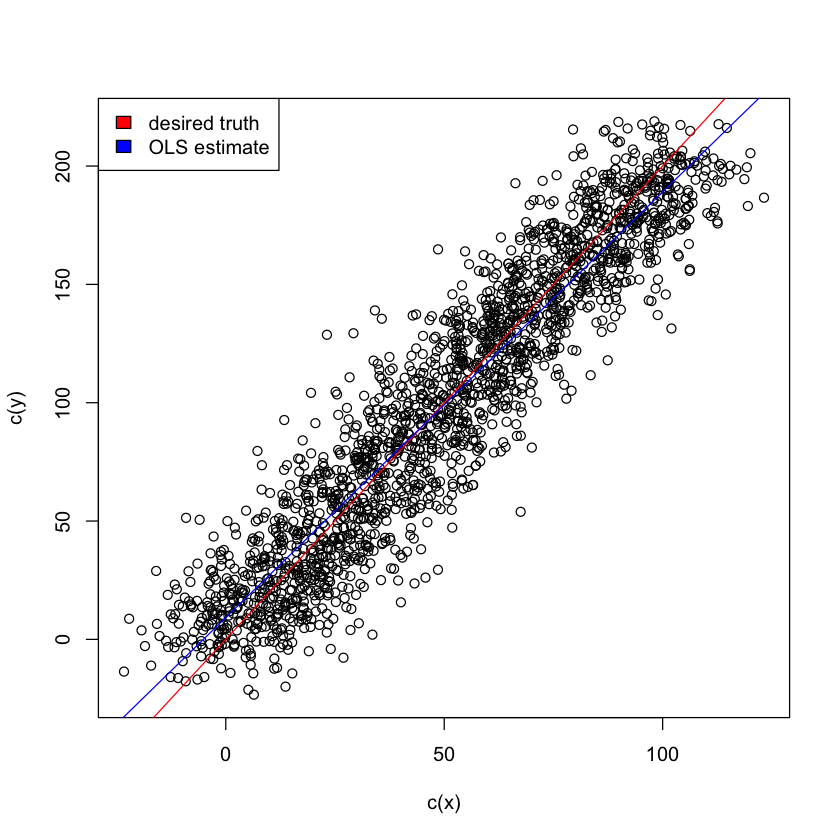

In [133]:
plot(c(x), c(y))
abline(a=0, b=alpha, col="red")
abline(lm(c(y) ~ c(x)), col="blue")
legend("topleft", legend=c("desired truth", "OLS estimate"), fill=c("red", "blue"))

#### Simulate from the true statistical model to see the long term behavior of least squares

In [134]:
sim_num <- 1000
out <- matrix(NA, ncol=2, nrow=sim_num)
for(i in seq_len(sim_num)){
    x <- sapply(mu_x, function(mux_i) rnorm(n, mux_i, sd=sqrt(sigma2)))
    y <- sapply(mu_y, function(muy_i) rnorm(n, muy_i, sd=sqrt(sigma2)))
    ols <- lm(c(y) ~ c(x))
    out[i, ] <- ols$coefficients
}

NULL

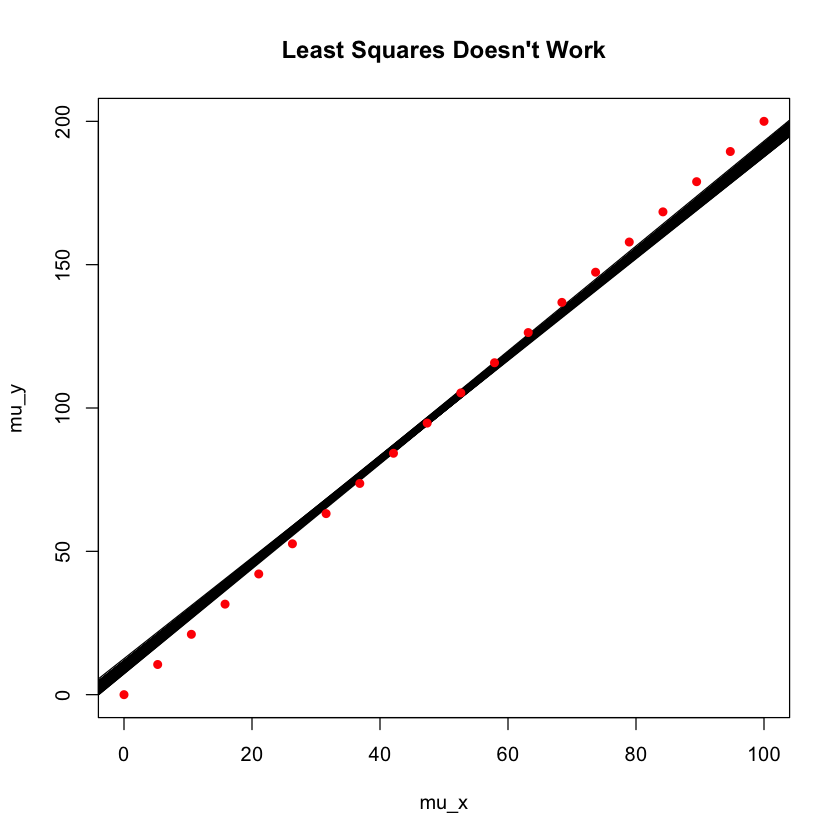

In [135]:
plot(mu_x, mu_y, type="n", col="red", main="Least Squares Doesn't Work")
apply(out, 1, function(x) abline(a=x[1], b=x[2]))
points(mu_x, mu_y, pch=16, col="red")

#### My points: your estimated slope is biased (the second value is the slope, first is the intercept)

In [136]:
apply(out, 2, mean)

[1] 9.788239 1.804481

In [137]:
apply(out, 2, sd)

[1] 0.8055201 0.0135007

#### What to do? Delta Method

First, recognize that $g$ is a continuous transform on the vector $\binom{\mu_x(e)}{\mu_y(e)}$:
$$\alpha = g\binom{\mu_x(e)}{\mu_y(e)} = \mu_y(e) / \mu_x(e)$$

We also know that $\hat{\mu}_x(e) = \sum_i x_i(e) \stackrel{n\to\infty}{\to} \mu_x(e)$, and similarly for $\hat{\mu}_y(e)$. So we know that

$$g\binom{\hat{\mu}_x(e)}{\hat{\mu}_y(e)} - g\binom{\mu_x(e)}{\mu_y(e)} \stackrel{n\to \infty}{\Rightarrow} N\left(0, \underbrace{\nabla g\binom{\mu_x(e)}{\mu_y(e)}^T \Sigma \nabla g\binom{\mu_x(e)}{\mu_y(e)}}_{=\sigma^2_g(e)}\right)$$

$$\nabla g\binom{\mu_x(e)}{\mu_y(e)} = \binom{-\frac{\mu_y(e)}{\mu_x^2(e)}}{\frac{1}{\mu_x(e)}}$$

In practice, this means a weighted average should work (based on plug in estimates): 
$$\hat{\alpha} = \sum_e g\binom{\hat{\mu}_x(e)}{\hat{\mu}_y(e)} \hat{\sigma}_g^{-1}(e) / \left( \sum_e \hat{\sigma}_g^{-1}(e) \right)$$

In [138]:
mux_hat <- apply(x, 2, mean)
muy_hat <- apply(y, 2, mean)

In [139]:
nabla_g <- function(mux, muy) {
    return(rbind(-muy / mux^2, 1/mux))
}
nabla_g_hat <- nabla_g(mux_hat, muy_hat)

In [140]:
covs <- sapply(1:num_exp, function(i) cov(cbind(x[, i], y[, i])))

In [141]:
sigma2_hat <- matrix(apply(covs, 1, mean), nrow=2)

In [142]:
sigma2_hat

97.564411,-2.279884
-2.279884,97.328595


In [143]:
dim(sigma2_hat)

[1] 2 2

In [144]:
dim(nabla_g_hat)

[1]  2 20

In [145]:
weights <- diag(t(nabla_g_hat) %*% sigma2_hat %*% nabla_g_hat)

In [146]:
weights # Notice the first point, with mu_x(0) = 0, has a very high variance

[1] 218.79080676  17.23136981   4.54142430   1.63824629   1.11040744
 [6]   0.77156639   0.73902251   0.37881108   0.32241024   0.23822146
[11]   0.17890290   0.16064060   0.12354537   0.09767170   0.09826400
[16]   0.07512233   0.07077631   0.05803235   0.05391676   0.04832423

In [147]:
weighted.mean(muy_hat / mux_hat, 1/sqrt(weights))

[1] 2.003703

In [148]:
summary(lm(c(y)~c(x)))


Call:
lm(formula = c(y) ~ c(x))

Residuals:
    Min      1Q  Median      3Q     Max 
-66.992 -14.144   0.487  13.547  72.328 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 11.33031    0.87240   12.99   <2e-16 ***
c(x)         1.78375    0.01467  121.55   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 21.2 on 1998 degrees of freedom
Multiple R-squared:  0.8809,	Adjusted R-squared:  0.8808 
F-statistic: 1.477e+04 on 1 and 1998 DF,  p-value: < 2.2e-16
